1. having a garage in different parts of the city
2. (1)+ the scarcity of garages in this neighberhood
3. (2)+ the number of cars your garage can host (more specifically garage cars>1)

## intro

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%pylab inline

train = pd.read_csv('../data/train.csv')

train=train[train.GrLivArea<4000]
train=train[train.LotArea<100000]
train.drop(['HouseStyle','BldgType','GarageCars','Utilities'], axis=1, inplace=True)

Populating the interactive namespace from numpy and matplotlib


In [19]:
train[train.GarageArea>0].groupby('Neighborhood').Id.count()/train.groupby('Neighborhood').Id.count()

Neighborhood
Blmngtn    1.000000
Blueste    1.000000
BrDale     0.937500
BrkSide    0.827586
ClearCr    0.961538
CollgCr    0.986667
Crawfor    1.000000
Edwards    0.775510
Gilbert    1.000000
IDOTRR     0.783784
MeadowV    0.705882
Mitchel    0.897959
NAmes      0.973333
NPkVill    1.000000
NWAmes     1.000000
NoRidge    1.000000
NridgHt    1.000000
OldTown    0.893805
SWISU      0.800000
Sawyer     0.959459
SawyerW    0.983051
Somerst    1.000000
StoneBr    1.000000
Timber     1.000000
Veenker    1.000000
Name: Id, dtype: float64

## 1

In [20]:
def turn_garage_data_into_dummy(df):
    for i in df.Neighborhood.unique().tolist():
        name="Garage_in_"+str(i)
        df[name]=np.where((df.Neighborhood==i)&(df.GarageArea!=0),1,0)
        
turn_garage_data_into_dummy(train)

In [25]:
fix1=train[train.Exterior2nd=='Brk Cmn'].index.tolist()
train.loc[fix1,'Exterior2nd']='BrkComm'

fix2=train[train.Exterior2nd=='Wd Shng'].index.tolist()
train.loc[fix2,'Exterior2nd']='WdShing'

fix3=train[train.Exterior2nd=='CmentBd'].index.tolist()
train.loc[fix3,'Exterior2nd']='CemntBd'

train['Diff_in_Ext']=train.apply(lambda x: 1 if x.Exterior2nd!=x.Exterior1st else 0, axis=1)

map_overall_to_cat={10:'High',9:'High',8:'High',7:'Average',6:'Average',5:'Average',4:'Average',
                    3:'Low',2:'Low',1:'Low'}

train.OverallCond=train.OverallCond.map(map_overall_to_cat)
train.OverallQual=train.OverallQual.map(map_overall_to_cat)

cat_c=[]
for c in train.columns.tolist():
    if train[c].dtypes=='object':
        cat_c.append(c)
cat_c.remove('MSZoning')
#cat_c.remove('Alley')
#cat_c.remove('MiscFeature')
cat_c

['Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [26]:
def make_dummies_conditional_on_len(train,c):
    df=train.groupby(c).Id.count()
    for i in df.index.tolist():
        if df.loc[i]>=50:
            name=str(c)+'_'+str(i)
            train[name]=np.where(train[c]==i,1,0)
    train.drop(c,axis=1, inplace=True)

for c in cat_c:
    make_dummies_conditional_on_len(train,c)

train.drop(['SaleType_New', 'CentralAir_Y','LandSlope_Gtl' ,'BsmtFinType2_Unf',
            'Foundation_PConc','RoofStyle_Gable', 'PavedDrive_Y','Electrical_SBrkr'], axis=1,inplace=True)


train.shape

(1452, 158)

In [27]:
LotFrontage_to_fix=train[train.LotFrontage.isnull()].index.tolist()
train.loc[LotFrontage_to_fix,'LotFrontage']=train.LotFrontage.mean()

MasVnrArea_to_fix=train[train.MasVnrArea.isnull()].index.tolist()
train.loc[MasVnrArea_to_fix,'MasVnrArea']=0

GarageYrBlt_to_fix=train[train.GarageYrBlt.isnull()].index.tolist()
train.loc[GarageYrBlt_to_fix,'GarageYrBlt']=train.GarageYrBlt.mean().round(0)

def turn_MS_data_into_cat(df):
    for i in df.MSSubClass.unique().tolist():
        for j in df.MSZoning.unique().tolist():
            if df[(df.MSSubClass==i)&(df.MSZoning==j)].Id.count()>=20:
                name=str(i)+'_'+str(j)
                df[name]=np.where((df.MSSubClass==i)&(df.MSZoning==j),1,0)
    df.drop(['MSSubClass','MSZoning'], axis=1, inplace=True)
turn_MS_data_into_cat(train)

train.drop('YearBuilt', axis=1, inplace=True)

train.loc[train[train.YearRemodAdd>train.YrSold].index,'YearRemodAdd']=2007

train['Avg_room_size']=train.GrLivArea/train.TotRmsAbvGrd

train=pd.concat([train,pd.get_dummies(train.BedroomAbvGr, prefix="br")], axis=1)
train.drop('br_8', axis=1, inplace=True)

train.shape

(1452, 179)

In [28]:
train['SaleDate']=train.apply(lambda x: str(int(x.YrSold))+'-'+str(int(x.MoSold))+'-'+str(1), axis=1)
train['SaleDate']=pd.to_datetime(train['SaleDate'])

n_transaction=train.groupby('SaleDate').size()
train['n_transaction']=n_transaction.loc[train.SaleDate].values
train['Log_sale_price']=np.log10(train.SalePrice)
train.drop('SalePrice', axis=1, inplace=True)

def backwardElimination(X, Y):
    for i in np.arange(0.9,0,-0.1):
        numVars = len(X.columns.tolist())
        d=[]
        regressor_OLS = sm.OLS(Y, X).fit()
        for j in range(numVars):
            if regressor_OLS.pvalues[j] > i:
                d.append(X.columns[j])
        for t in d:
            X=X.drop(t, axis=1)
    
    regressor_OLS = sm.OLS(Y, X).fit()
    while max(regressor_OLS.pvalues > i):
        numVars = len(X.columns.tolist())
        d=[]
        for j in range(numVars):
            if regressor_OLS.pvalues[j] > i:
                d.append(X.columns[j])
        for t in d:
            X=X.drop(t, axis=1)
        regressor_OLS = sm.OLS(Y, X).fit()
    
    print(regressor_OLS.summary())
    
    return regressor_OLS, X.columns.tolist()

def predicting(train, list_to_remove):
    columns_to_keep=train.columns.tolist()
    for i in list_to_remove:
        columns_to_keep.remove(i)

    X=train[columns_to_keep]
    y=train.Log_sale_price
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    regressor_OLS = sm.OLS(y_train,x_train).fit()
    print(regressor_OLS.summary())
    
    y_pred=regressor_OLS.predict(x_test)
    mse = mean_squared_error(y_pred,y_test)
    rmse = np.sqrt(mse)
    print("\n rmse on all var's is: ", rmse)   
    
    regressor, ctp=backwardElimination(x_train,y_train)
    
    y_pred2=regressor.predict(x_test[ctp])
    mse2 = mean_squared_error(y_pred2,y_test)
    rmse2 = np.sqrt(mse2)
    print("\n rmse on best var's is: ", rmse2)

    return y_pred, y_pred2,y_test,ctp,regressor

def plotting_pred(y_pred,y_test,y_pred2):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,2,1)
    ax.scatter(y_pred,y_test, s=5)
    ax.set_title('prediction of log10 prices')
    ax.set_xlabel('predicted price')
    ax.set_ylabel('real price')

    bx = fig.add_subplot(1,2,2)
    bx.scatter(y_pred2,y_test, s=5)
    bx.set_title('prediction of log10 prices')
    bx.set_xlabel('predicted price')
    bx.set_ylabel('real price')

    fig.show()

In [29]:
y_pred, y_pred2,y_test,ctp,regressor=predicting(train,['Log_sale_price','SaleDate', 'Id','YrSold','MoSold'])

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     69.53
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        12:23:24   Log-Likelihood:                 1712.4
No. Observations:                1016   AIC:                            -3093.
Df Residuals:                     850   BIC:                            -2275.
Df Model:                         165                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotFrontage            1.638e-

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     154.5
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        12:23:25   Log-Likelihood:                 1669.7
No. Observations:                1016   AIC:                            -3187.
Df Residuals:                     940   BIC:                            -2813.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotArea                1.475e-

C:\Users\liort\Anaconda3\envs\py4dp\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


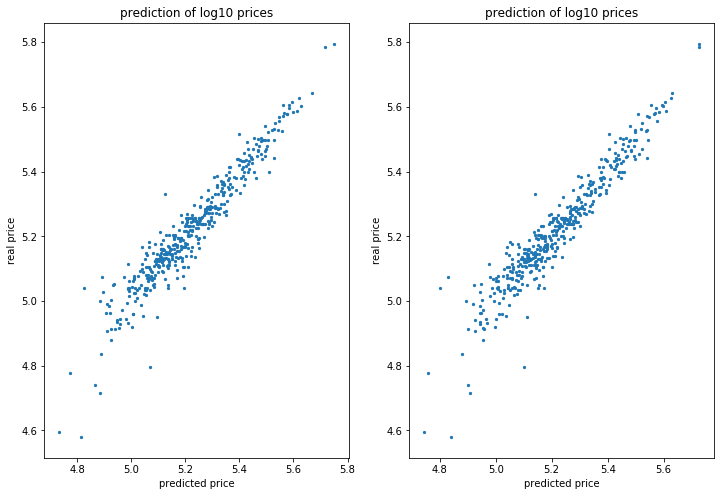

In [30]:
plotting_pred(y_pred,y_test,y_pred2)

some of the garage in neighberhood dummies stayed significant. it also affected other garage coef_

there is also a small change in rmse, but n-transaction lost significant. lets try to plug other data in (like in lior 06)

In [31]:
usa_sale_prices=pd.read_csv("../data/USA-House_prices_monthly_excat_dates.csv")
usa_sale_prices.DATE=pd.to_datetime(usa_sale_prices.DATE, infer_datetime_format=True)
usa_sale_prices.DATE=usa_sale_prices.DATE.dt.strftime('%Y-%d-%m')
usa_sale_prices.DATE=pd.to_datetime(usa_sale_prices.DATE, infer_datetime_format=True)
usa_sale_prices.set_index('DATE', inplace=True)
train['Price_index']=usa_sale_prices.loc[train.SaleDate].values
y_pred, y_pred2,y_test,ctp,regressor=predicting(train,['Log_sale_price','SaleDate', 'Id','YrSold','MoSold'])

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     69.32
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:34:22   Log-Likelihood:                 1714.4
No. Observations:                1016   AIC:                            -3095.
Df Residuals:                     849   BIC:                            -2273.
Df Model:                         166                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotFrontage            1.007e-

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     154.6
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:34:25   Log-Likelihood:                 1669.9
No. Observations:                1016   AIC:                            -3188.
Df Residuals:                     940   BIC:                            -2814.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotArea                1.528e-

the usa data didnt work but now n-transaction is significant. it means we have high multicoleaniarity and we need to take care of that.

also the rmse is a bit lower

In [32]:
Ames_sale_prices_Q=pd.read_csv("../data/Ames_House_prices.csv")
Ames_sale_prices_Q.DATE=pd.to_datetime(Ames_sale_prices_Q.DATE)
Ames_sale_prices_Q.set_index('DATE', inplace=True)

timerange=[]
for i in range(2006,2011):
    for j in range(1,13):
        timerange.append(str(i)+'-'+str(j)+'-'+str(1))
timerange=pd.to_datetime(timerange)

Ames_sale_prices_M=pd.DataFrame(data=np.nan, index=np.arange(55), columns=['Date','Value'])
Ames_sale_prices_M.Date=timerange[:-5]
Ames_sale_prices_M.set_index('Date', inplace=True)

Ames_sale_prices_M.Value=Ames_sale_prices_Q.loc[Ames_sale_prices_M.index].values

def fancy_forward_fill(Ames_sale_prices_M):
    for i in range(0,52,3):
        v0=Ames_sale_prices_M.iloc[i].values
        v1=Ames_sale_prices_M.iloc[i+3].values
        j=(v1-v0)/3
        Ames_sale_prices_M.iloc[i+1]=v0+j
        Ames_sale_prices_M.iloc[i+2]=v0+(2*j)
fancy_forward_fill(Ames_sale_prices_M)

train['Price_index_Ames']=Ames_sale_prices_M.loc[train.SaleDate].values
y_pred, y_pred2,y_test,ctp,regressor=predicting(train,['Log_sale_price','SaleDate', 'Id','YrSold','MoSold'])

C:\Users\liort\Anaconda3\envs\py4dp\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app


                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     69.10
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:37:44   Log-Likelihood:                 1716.3
No. Observations:                1016   AIC:                            -3097.
Df Residuals:                     848   BIC:                            -2269.
Df Model:                         167                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotFrontage            1.032e-

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     152.1
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:37:47   Log-Likelihood:                 1668.9
No. Observations:                1016   AIC:                            -3184.
Df Residuals:                     939   BIC:                            -2805.
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotArea                1.413e-

once again its not significant but rmse is again a bit lower. lastly we'll try unemployment

In [34]:
ue=pd.read_csv("../data/Unemployment in Ames.csv")
ue.DATE=pd.to_datetime(ue.DATE)
ue.set_index('DATE', inplace=True)
train['UnEmployment']=ue.loc[train.SaleDate].values
y_pred, y_pred2,y_test,ctp,regressor=predicting(train,['Log_sale_price','SaleDate', 'Id','YrSold','MoSold','Price_index','Price_index_Ames'])

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     69.55
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:41:45   Log-Likelihood:                 1716.0
No. Observations:                1016   AIC:                            -3098.
Df Residuals:                     849   BIC:                            -2276.
Df Model:                         166                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotFrontage            9.173e-

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     154.9
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:41:48   Log-Likelihood:                 1670.9
No. Observations:                1016   AIC:                            -3190.
Df Residuals:                     940   BIC:                            -2816.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotArea                1.533e-

C:\Users\liort\Anaconda3\envs\py4dp\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


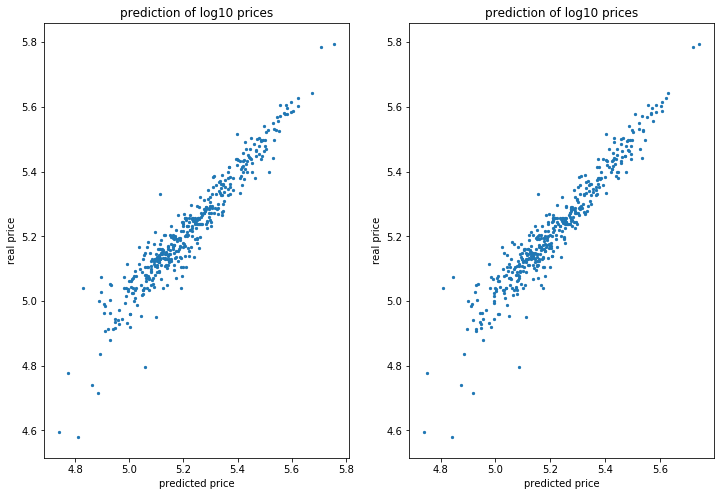

In [35]:
plotting_pred(y_pred,y_test,y_pred2)

In [36]:
train[train.Log_sale_price<4.8]

,Id,LotFrontage,LotArea,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,br_3,br_4,br_5,br_6,SaleDate,n_transaction,Log_sale_price,Price_index,Price_index_Ames,UnEmployment
30,31,50.000000,8500,1950,0.0,0,0,649,649,649,...,1,0,0,0,2008-07-01,49,4.602060,207.22,156.270000,3.5
375,376,69.626254,10020,1950,0.0,350,0,333,683,904,...,0,0,0,0,2009-03-01,19,4.785330,193.81,158.293333,4.8
410,411,68.000000,9571,1958,0.0,0,0,1276,1276,1276,...,1,0,0,0,2009-06-01,58,4.778151,196.07,156.846667,5.7
462,463,60.000000,8281,1965,0.0,553,311,0,864,864,...,1,0,0,0,2009-12-01,15,4.795066,190.00,154.966667,4.7
495,496,60.000000,7879,1950,0.0,495,0,225,720,720,...,0,0,0,0,2009-11-01,22,4.542825,193.31,156.253333,4.3
533,534,50.000000,5000,1950,0.0,0,0,0,0,334,...,0,0,0,0,2007-01-01,12,4.594393,223.75,154.600000,2.9
636,637,51.000000,6120,1950,0.0,0,0,264,264,800,...,0,0,0,0,2009-01-01,12,4.778151,194.77,159.320000,4.5
705,706,70.000000,5600,1950,0.0,0,0,0,0,372,...,1,0,0,0,2010-07-01,6,4.740363,190.31,157.440000,4.3
710,711,56.000000,4130,2003,0.0,0,0,270,270,729,...,0,0,0,0,2008-07-01,49,4.716003,207.22,156.270000,3.5
812,813,66.000000,8712,1952,0.0,0,0,540,540,1044,...,0,0,0,0,2010-06-01,36,4.748134,191.74,157.373333,4.7


In [43]:
y_pred, y_pred2,y_test,ctp,regressor=predicting(train,['Log_sale_price','SaleDate', 'Id','YrSold','MoSold'])

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     68.50
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:53:33   Log-Likelihood:                 1718.9
No. Observations:                1016   AIC:                            -3098.
Df Residuals:                     846   BIC:                            -2261.
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotFrontage            8.472e-

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     152.7
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:53:35   Log-Likelihood:                 1671.1
No. Observations:                1016   AIC:                            -3188.
Df Residuals:                     939   BIC:                            -2809.
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotArea                1.433e-

In [57]:
train['Old_house']=train.apply(lambda x: 1 if x.YearRemodAdd<=1950 else 0, axis=1)

from garageyrblt we can learn the true agea of the house (in cases it was built before 1950).
we can also learn about houses that the garage was add on later. lets try this 2 new var's

In [48]:
train['Addon_garage']=train.apply(lambda x: 1 if x.YearRemodAdd<x.GarageYrBlt else 0,axis=1)

In [49]:
train.loc[(train.YearRemodAdd==1950)&(train.GarageYrBlt<1950)]

,Id,LotFrontage,LotArea,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,br_5,br_6,SaleDate,n_transaction,Log_sale_price,Price_index,Price_index_Ames,UnEmployment,Old_house,Addon_garage
8,9,51.000000,6120,1950,0.0,0,0,952,952,1022,...,0,0,2008-04-01,26,5.113609,210.76,157.730000,2.8,1,0
9,10,50.000000,7420,1950,0.0,851,0,140,991,1077,...,0,0,2008-01-01,12,5.071882,213.54,159.990000,3.1,1,0
21,22,57.000000,7449,1950,0.0,0,0,637,637,1108,...,0,0,2007-06-01,57,5.144263,227.72,157.336667,3.3,1,0
29,30,60.000000,6324,1950,0.0,0,0,520,520,520,...,0,0,2008-05-01,38,4.835691,209.86,157.243333,3.0,1,0
30,31,50.000000,8500,1950,0.0,0,0,649,649,649,...,0,0,2008-07-01,49,4.602060,207.22,156.270000,3.5,1,0
68,69,47.000000,4608,1950,0.0,0,0,747,747,747,...,0,0,2010-06-01,36,4.903090,191.74,157.373333,4.7,1,0
74,75,60.000000,5790,1950,0.0,0,0,840,840,840,...,0,0,2010-05-01,48,5.031004,192.79,157.306667,4.0,1,0
98,99,85.000000,10625,1950,0.0,108,0,350,458,835,...,0,0,2010-05-01,48,4.919078,192.79,157.306667,4.0,1,0
107,108,50.000000,6000,1950,0.0,104,169,516,789,789,...,0,0,2008-04-01,26,5.060698,210.76,157.730000,2.8,1,0
149,150,69.626254,6240,1950,0.0,0,0,896,896,896,...,0,0,2006-04-01,27,5.060698,223.44,155.750000,2.4,1,0


In [50]:
train.YearRemodAdd=train.apply(lambda x: x.GarageYrBlt if ((x.YearRemodAdd==1950)&(x.GarageYrBlt<1950)) else x.YearRemodAdd, axis=1)

In [60]:
y_pred, y_pred2,y_test,ctp,regressor=predicting(train,['Log_sale_price','SaleDate', 'Id','YrSold','MoSold','Price_index','Price_index_Ames','Old_house','Addon_garage'])

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     69.26
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        18:19:11   Log-Likelihood:                 1714.0
No. Observations:                1016   AIC:                            -3094.
Df Residuals:                     849   BIC:                            -2272.
Df Model:                         166                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotFrontage            7.012e-

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     166.5
Date:                Sat, 17 Nov 2018   Prob (F-statistic):               0.00
Time:                        18:19:12   Log-Likelihood:                 1655.5
No. Observations:                1016   AIC:                            -3173.
Df Residuals:                     947   BIC:                            -2833.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotArea                 1.49e-

C:\Users\liort\Anaconda3\envs\py4dp\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


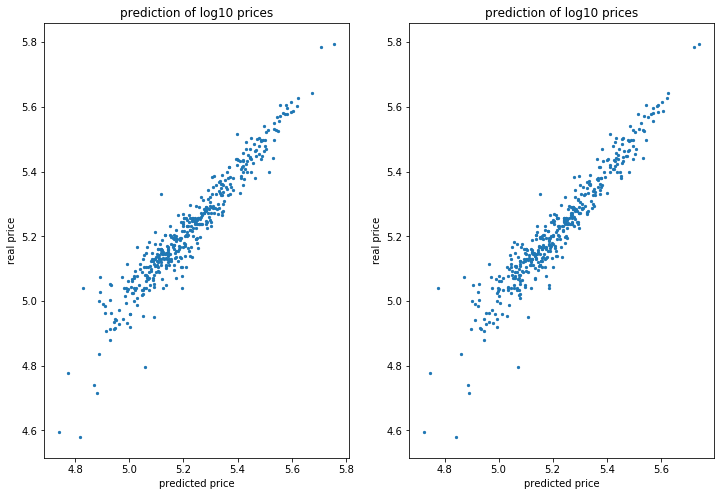

In [61]:
plotting_pred(y_pred,y_test,y_pred2)

looking good, let's submit

In [64]:
test= pd.read_csv('../data/test.csv')

fix_year=test.loc[test.GarageYrBlt>2010].GarageYrBlt.index.values.tolist()
test.loc[fix_year,'GarageYrBlt']=np.nan

fix4=test[test.Exterior2nd=='Brk Cmn'].index.tolist()
test.loc[fix4,'Exterior2nd']='BrkComm'

fix5=test[test.Exterior2nd=='Wd Shng'].index.tolist()
test.loc[fix5,'Exterior2nd']='WdShing'

fix6=test[test.Exterior2nd=='CmentBd'].index.tolist()
test.loc[fix6,'Exterior2nd']='CemntBd'

test.loc[test[test.YearRemodAdd>test.YrSold].index, 'YearRemodAdd']=2007 


test.OverallCond=test.OverallCond.map(map_overall_to_cat)
test.OverallQual=test.OverallQual.map(map_overall_to_cat)
test['Diff_in_Ext']=test.apply(lambda x: 1 if x.Exterior2nd!=x.Exterior1st else 0, axis=1)

for c in cat_c:
    test=pd.concat([test,pd.get_dummies(test[c], prefix=c)], axis=1)

turn_MS_data_into_cat(test)

test=pd.concat([test,pd.get_dummies(test.BedroomAbvGr, prefix="br")], axis=1)

test['SaleDate']=test.apply(lambda x: str(int(x.YrSold))+'-'+str(int(x.MoSold))+'-'+str(1), axis=1)
test['SaleDate']=pd.to_datetime(test['SaleDate'])
test['n_transaction']=n_transaction.loc[test.SaleDate].values

test['120_RM']=0
test['Avg_room_size']=test.GrLivArea/test.TotRmsAbvGrd


turn_garage_data_into_dummy(test)
test['UnEmployment']=ue.loc[test.SaleDate].values

test_X=test[ctp]
test_X.loc[:,test_X.isnull().any()].columns.tolist()

['BsmtFinSF1', 'TotalBsmtSF', 'GarageArea']

In [65]:
test.loc[test[test.GarageArea.isnull()==True].index.tolist(),'GarageArea']=0
test.loc[test[test.TotalBsmtSF.isnull()==True].index.tolist(),'TotalBsmtSF']=0
test.loc[test[test.BsmtFinSF1.isnull()==True].index.tolist(),'BsmtFinSF1']=0

test_X=test[ctp]
test_X.loc[:,test_X.isnull().any()].columns.tolist()

[]

In [66]:
test.YearRemodAdd=test.apply(lambda x: x.GarageYrBlt if ((x.YearRemodAdd==1950)&(x.GarageYrBlt<1950)) else x.YearRemodAdd, axis=1)

In [67]:
y_pred_test=regressor.predict(test_X)

y_pred_test.isnull().any()

False

In [68]:
SalePrice=pd.Series(10**y_pred_test, name='SalePrice')

test=test.join(SalePrice)

submission = test.loc[:, ['Id', 'SalePrice']].copy()
submission.set_index('Id', inplace=True)
submission.head()

,SalePrice
Id,
1461,121577.946181
1462,162006.380384
1463,195004.868524
1464,197399.033968
1465,196131.968282


In [69]:
submission.to_csv('../data/model08.csv')

a new small improvment. i think it's time to move to more sophisticated model like random forest

C:\Users\liort\Anaconda3\envs\py4dp\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


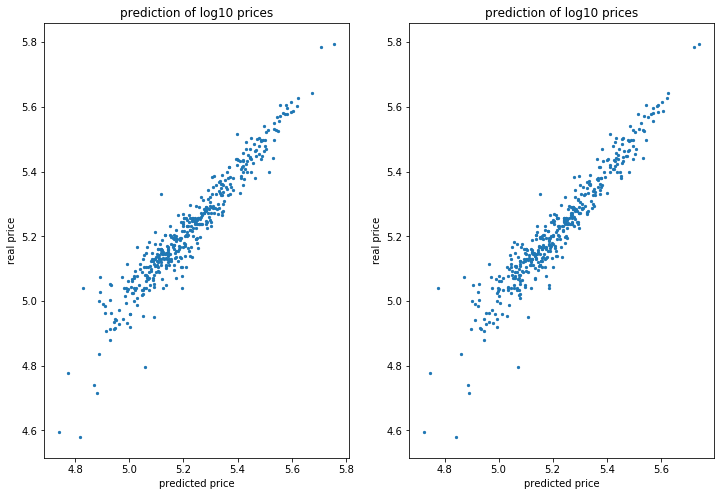

In [70]:
plotting_pred(y_pred,y_test,y_pred2)